In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
import os
import pandas as pd
import numpy as np
import cv2

base_dir = r'E:\AB\UEM\year 3\SEM 6\pneumonia_binary\train'
img_h,img_w= (164,164)
batch_size=8
epochs=3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen= ImageDataGenerator(horizontal_flip=True, vertical_flip=True,width_shift_range=0.2, height_shift_range=0.2,rescale=1./255,validation_split=0.2)

In [2]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ReduceLROnPlateau

base_model= ResNet50(include_top=False, weights='imagenet',
                                       input_tensor=None, input_shape=(img_h,img_w,3), pooling='avg')
 
for layer in base_model.layers[:-7]:
    layer.trainable=False

 
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())



model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 1,059,842
Non-trainable params: 22,531,968
_________________________________________________________________


In [3]:
for layer in base_model.layers:
    print(layer,"-->",layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000028490795B50> --> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000002849B284400> --> False
<keras.layers.convolutional.Conv2D object at 0x000002849B284790> --> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002849B2F9580> --> False
<keras.layers.core.activation.Activation object at 0x000002849B2F9280> --> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000002849B331BB0> --> False
<keras.layers.pooling.MaxPooling2D object at 0x000002849B487A30> --> False
<keras.layers.convolutional.Conv2D object at 0x000002849B4A9C10> --> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002849B4A4880> --> False
<keras.layers.core.activation.Activation object at 0x000002849B284DF0> --> False
<keras.layers.convolutional.Conv2D object at 0x000002849B5019D0> --> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000

In [3]:
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=3,
                                         cooldown=2,
                                         min_lr=1e-10,
                                         verbose=1)

checkpoint =tf.keras.callbacks.ModelCheckpoint(filepath="RES.h5", 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True, 
                            save_weights_only=False, 
                            mode='auto',
                            save_freq='epoch')


import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

callbacks = [reduce_learning_rate, checkpoint, time_callback]
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile( loss='binary_crossentropy',optimizer= optimizer, metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

F:\Anaconda\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [4]:
val_dir = r'E:\AB\UEM\year 3\SEM 6\pneumonia_binary\train'
train_generator = datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(img_h,img_w),  
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        #color_mode="rgb",
        shuffle=True)


validation_generator = datagen.flow_from_directory(
         val_dir,     
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode='categorical',
        #color_mode="rgb",
        subset='validation',
        shuffle=False)

Found 3354 images belonging to 2 classes.
Found 838 images belonging to 2 classes.


In [3]:
validation_generator

In [5]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples//batch_size, 
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//batch_size,  
      callbacks=callbacks,
      verbose=1)

Epoch 1/10
419/419 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.7567 - precision: 0.7549 - recall: 0.7531
Epoch 00001: val_accuracy improved from -inf to 0.76683, saving model to RES.h5


F:\Anaconda\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


419/419 [==============================] - 274s 633ms/step - loss: 0.5062 - accuracy: 0.7567 - precision: 0.7549 - recall: 0.7531 - val_loss: 0.5293 - val_accuracy: 0.7668 - val_precision: 0.7691 - val_recall: 0.7608 - lr: 0.0010
Epoch 2/10
419/419 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.7926 - precision: 0.7871 - recall: 0.7869
Epoch 00002: val_accuracy did not improve from 0.76683
419/419 [==============================] - 220s 524ms/step - loss: 0.4307 - accuracy: 0.7926 - precision: 0.7871 - recall: 0.7869 - val_loss: 0.5649 - val_accuracy: 0.7560 - val_precision: 0.7557 - val_recall: 0.7584 - lr: 0.0010
Epoch 3/10
419/419 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.7860 - precision: 0.7878 - recall: 0.7845
Epoch 00003: val_accuracy improved from 0.76683 to 0.80409, saving model to RES.h5
419/419 [==============================] - 219s 523ms/step - loss: 0.4252 - accuracy: 0.7860 - precision: 0.7878 - recall: 0.7845 - val_

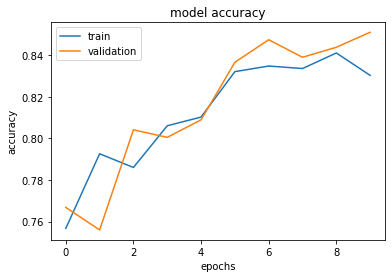

In [6]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='upper left')
plt.show()

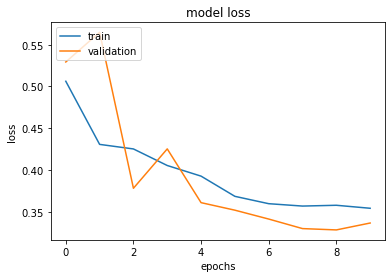

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='upper left')
plt.show()

In [7]:
model.evaluate(validation_generator,verbose=1)

105/105 [==============================] - 42s 403ms/step - loss: 0.3955 - accuracy: 0.7852 - precision: 0.7855 - recall: 0.7864


[0.39552852511405945,
 0.7852028608322144,
 0.7854588627815247,
 0.7863962054252625]

In [34]:
accu= history.history['val_accuracy']
print(max(accu),"at epoch number-",accu.index(max(accu))+1)

0.8449519276618958 at epoch number- 9


In [11]:
img = cv2.imread("E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\normal\\NORMAL2-IM-1261-0001.jpeg") 
image_resized= cv2.resize(img, (img_h,img_w))

img=np.expand_dims(image_resized,axis=0)
np.set_printoptions(suppress=True)
pred=model.predict(img)
#print(pred);
yn=np.argmax(pred,axis=1)
if yn==0:
    print("Pneumonia")
else :
    print("Not")

Not


In [ ]:
'''cv2.imshow('CT scan', img)
cv2.waitKey(0)
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\normal\\NORMAL2-IM-1261-0001.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\test\\opacity\\person17_virus_48.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\normal\\NORMAL2-IM-1102-0001-0002.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\opacity\\person1453_bacteria_3771.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\test\\opacity\\person47_virus_99.jpeg
'''

In [12]:
pred

array([[0.00000119, 1.        ]], dtype=float32)

In [13]:
model2= tf.keras.models.load_model("RES.h5")
y_pred= model2.predict(validation_generator,verbose=1)
y_true= validation_generator.classes
y_pred2= np.argmax(y_pred,axis=1)

#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_true,y_pred2))
from sklearn.metrics import confusion_matrix

cf=confusion_matrix(y_true, y_pred2)

105/105 [==============================] - 38s 359ms/step


In [14]:
cf

array([[ 69, 147],
       [ 27, 595]], dtype=int64)

In [15]:
img=validation_generator[8]

In [19]:
#pred=model.predict(img)
img=cv2.resize(img, (img_h,img_w))
img=np.expand_dims(image_resized,axis=0)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'
